# GLM @ KTH with If Insurance
This is a code template for project 2 in the course SF2930 regression Analysis. 

* Questions regarding this lab can be sent to Majken or Ellinor from If (contact information on Canvas)
* Questions regarding the report are referred to the course resposibles from KTH's side.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import glm
import re

# Read data
* Provided data in GLM_KTH_Data_Train.csv is read into a table
* Note that the folder in which you have GLM_KTH_Data_Train.csv must be set as the working directory
* You don't need to change anything in this section

In [4]:
df = pd.read_csv(
    r"GLM_KTH_Data_Train.csv",
    sep=",",
    decimal=".",
)

In [5]:
df_eval = pd.read_csv(
    r"GLM_KTH_Data_Eval.csv",
    sep=",",
    decimal=".",
)

In [6]:
# Initial check on number of rows and columns
n_rows = df.shape[0]
n_columns = df.shape[1]
print(f"Number iof rows: {n_rows}\nNumber of columns: {n_columns}")

Number iof rows: 149486
Number of columns: 10


Here we are given training data from 2018-2022 with observed claims and policy duration

In [7]:
df

,RiskYear,NumberOfPersons,ActivityCode,TravellingArea,DangerousAreas,CompanyAge,FinancialRating,Duration,ClaimCost,NumberOfClaims
0,2018,58.0,L,Whole world,Excluded,70.075294,AA,0.9994,0.0,0
1,2018,30.0,G,Whole world,Excluded,66.841890,AAA,0.2519,0.0,0
2,2018,150.0,C,Whole world,Excluded,60.876114,AA,0.3340,0.0,0
3,2021,54.0,Q,Whole world,Excluded,63.608486,AAA,0.4956,0.0,0
4,2019,19.0,R,Whole world,Excluded,31.096510,A,0.8625,0.0,0
...,...,...,...,...,...,...,...,...,...,...
149481,2022,1.0,M,Sweden,Excluded,3.687885,AA,0.9720,0.0,0
149482,2022,2.0,R,Whole world,Excluded,1.938398,B,0.7366,0.0,0
149483,2018,2.0,F,Sweden,Excluded,20.999315,missing,0.5230,0.0,0
149484,2020,1.0,F,Sweden,Excluded,2.469541,missing,0.3970,0.0,0


In evaluation we have data from 2023-2024 where we do not know the amount of claims, or the number of claims, this is the data we want to price moving forward

In [8]:
df_eval

,PolID,RiskYear,NumberOfPersons,ActivityCode,TravellingArea,DangerousAreas,CompanyAge,FinancialRating
0,735711995,2023,2.0,L,Whole world,Excluded,26.165640,missing
1,1056243793,2023,4.0,C,Whole world,Excluded,125.316910,AAA
2,579474384,2024,3.0,Q,Whole world,Excluded,66.606440,AAA
3,-1918921610,2023,1.0,G,Whole world,Excluded,43.460644,AA
4,1639132189,2024,50.0,L,Whole world,Excluded,42.447640,AA
...,...,...,...,...,...,...,...,...
79626,1062849252,2024,2.0,L,Whole world,Excluded,57.043120,missing
79627,1996410447,2024,1.0,C,Sweden,Excluded,4.840520,missing
79628,1994070800,2023,2.0,G,Sweden,Excluded,2.680356,B
79629,-1429299204,2024,1.0,M,Whole world,Excluded,0.717317,IR


# Exploration
* Check distribution of average claim size and number of claims
* Check if claim cost and number of claims vary between risk years

In [9]:
df["AvgClaimCost"] = df["ClaimCost"] / df["NumberOfClaims"]

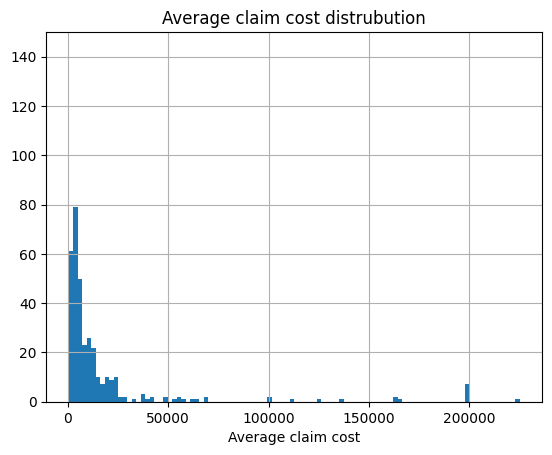

In [10]:
df["AvgClaimCost"].hist(bins=100)
plt.ylim((0, 150))  # limit y-axis due to high density at 0
plt.xlabel("Average claim cost")
plt.title("Average claim cost distrubution")
plt.show()

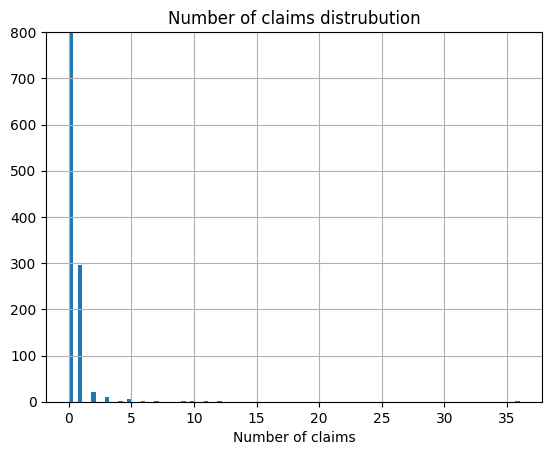

In [11]:
df["NumberOfClaims"].hist(bins=100)
plt.ylim((0, 800))  # limit y-axis due to high density at 0
plt.xlabel("Number of claims")
plt.title("Number of claims distrubution")
plt.show()

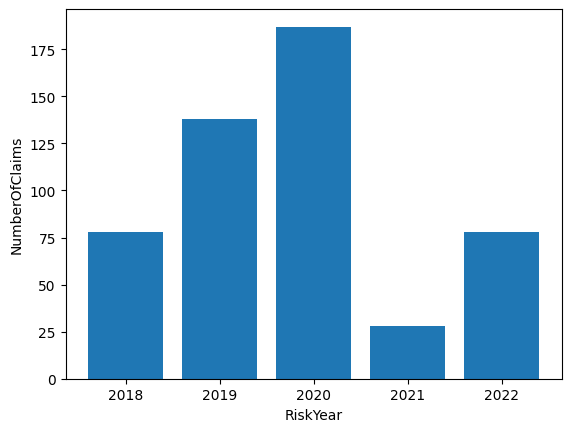

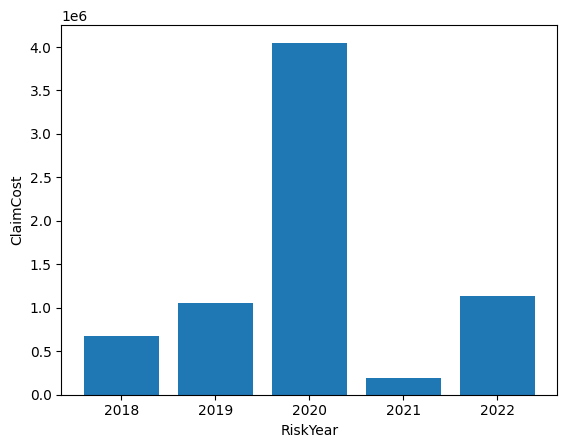

In [12]:
# Aggregate per RiskYear to see development over time
agg_dict = {"NumberOfClaims": "sum", "ClaimCost": "sum"}
df_agg_ry = df.groupby("RiskYear").agg(agg_dict)

for var in agg_dict:
    plt.bar(df_agg_ry.index, df_agg_ry[var])
    plt.xlabel(df_agg_ry.index.name)
    plt.ylabel(var)
    plt.show()

# Preprocess data
Now you need to modify your data so that you can perform a GLM analysis. Specifically this includes grouping your variables into tariff cells.

## Grouping
The groupings below are only examples, you need to create your own groups, with breaks that suit your data.

Remember to think about risk homogeneous and stable groups, for example having groups with zero number of caims or claims cost and almost no Duration makes it hard to determine its risk.

### Group numerical variables
When grouping numerical variables we can specify the group edges and labels, and then let pandas cut()-function do the job.

It is important that there are claims and claim cost in each resulting group. Therefore it is always a good idea to check some statistics after doing the grouping.

In [13]:
variable = "NumberOfPersons"
grouped_variable_name = "NoPGroup"
bin_edges = [-np.inf, 5, 15, 50, 100, np.inf]
bin_labels = ["01.<4", "02. 5-14", "03. 15-49", "04. 50-99", "05. >=100"]

df[grouped_variable_name] = pd.cut(
    df[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=False,
)
df_eval[grouped_variable_name] = pd.cut(
    df_eval[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=False,
)

#### Check on the resulting groups
- Make sure there are claims in each group
- Plot frequency, severity, claim cost and duration per group to see the marginal factors and how much duration we have in each group

In [14]:
# How to aggregate the data to see how many rows, claims and how much claim cost there is in each category
aggregations = {
    "Duration": "sum",
    "NumberOfClaims": "sum",
    "ClaimCost": "sum",
}

# Do the aggregation and renamning
df_agg_stat = (
    df.groupby(grouped_variable_name).agg(aggregations)
)

# Display the aggregated data
print(df_agg_stat)

             Duration  NumberOfClaims   ClaimCost
NoPGroup                                         
01.<4      46158.3153             106   858249.13
02. 5-14   14704.3350              71  1383089.86
03. 15-49   7200.5835              75  1218041.61
04. 50-99   2067.7060              38   919068.00
05. >=100   3376.9380             219  2736044.72


/var/folders/ff/6hp3dqg92056jj3syv25sgg40000gn/T/ipykernel_19732/2664428338.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(grouped_variable_name).agg(aggregations)


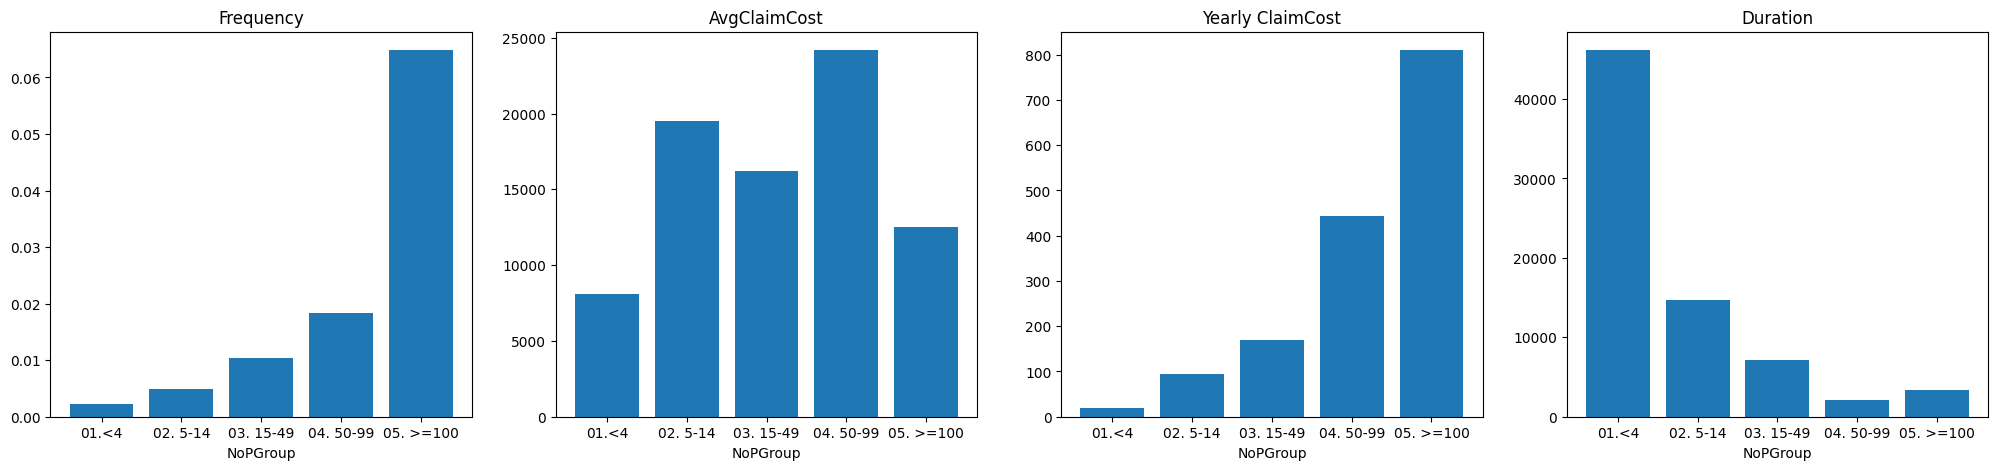

In [15]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["NumberOfClaims"] / df_agg_stat["Duration"])
plt.title("Frequency")

plt.subplot(142)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["NumberOfClaims"])
plt.title("AvgClaimCost")

plt.subplot(143)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["Duration"])
plt.title("Yearly ClaimCost")

plt.subplot(144)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["Duration"])
plt.title("Duration")

plt.show()

### Group categorical variables
When grouping categorical variables we can for each current category specify the new category, and then let pandas replace()-function do the job.

As for numerical variables, it is important that there are claims and claim cost in each resulting group. Therefore it is always a good idea to check some statistics after doing the grouping.

In [16]:
variable = "ActivityCode"
grouped_variable_name = "ActivityGroup"
grouping_map = {
    "A": "Other",
    "B": "Other",
    "C": "Other",
    "D": "Other",
    "E": "Other",
    "F": "Other",
    "G": "Service",
    "H": "Other",
    "I": "Service",
    "J": "Other",
    "K": "Other",
    "L": "Other",
    "M": "Other",
    "N": "Other",
    "O": "Other",
    "P": "Other",
    "Q": "Other",
    "R": "Other",
    "S": "Service",
    "T": "Service",
    "U": "Other",
    "X": "Other",
    "Missing": "Other",
}

df[grouped_variable_name] = df[variable].replace(to_replace=grouping_map)
df_eval[grouped_variable_name] = df_eval[variable].replace(to_replace=grouping_map)

#### Check on the resulting groups
- Make sure there are claims in each group
- Plot frequency, severity, claim cost and duration per group to see the marginal factors and how much duration we have in each group

In [17]:
# How to aggregate the data to see how many rows, claims and how much claim cost there is in each category
aggregations = {
    "Duration": "sum",
    "NumberOfClaims": "sum",
    "ClaimCost": "sum",
}

# Do the aggregation and renamning
df_agg_stat = (
    df.groupby(grouped_variable_name).agg(aggregations)
)

# Display the aggregated data
print(df_agg_stat)

                 Duration  NumberOfClaims   ClaimCost
ActivityGroup                                        
Other          61241.8314             416  5721396.58
Service        12266.0464              93  1393096.74


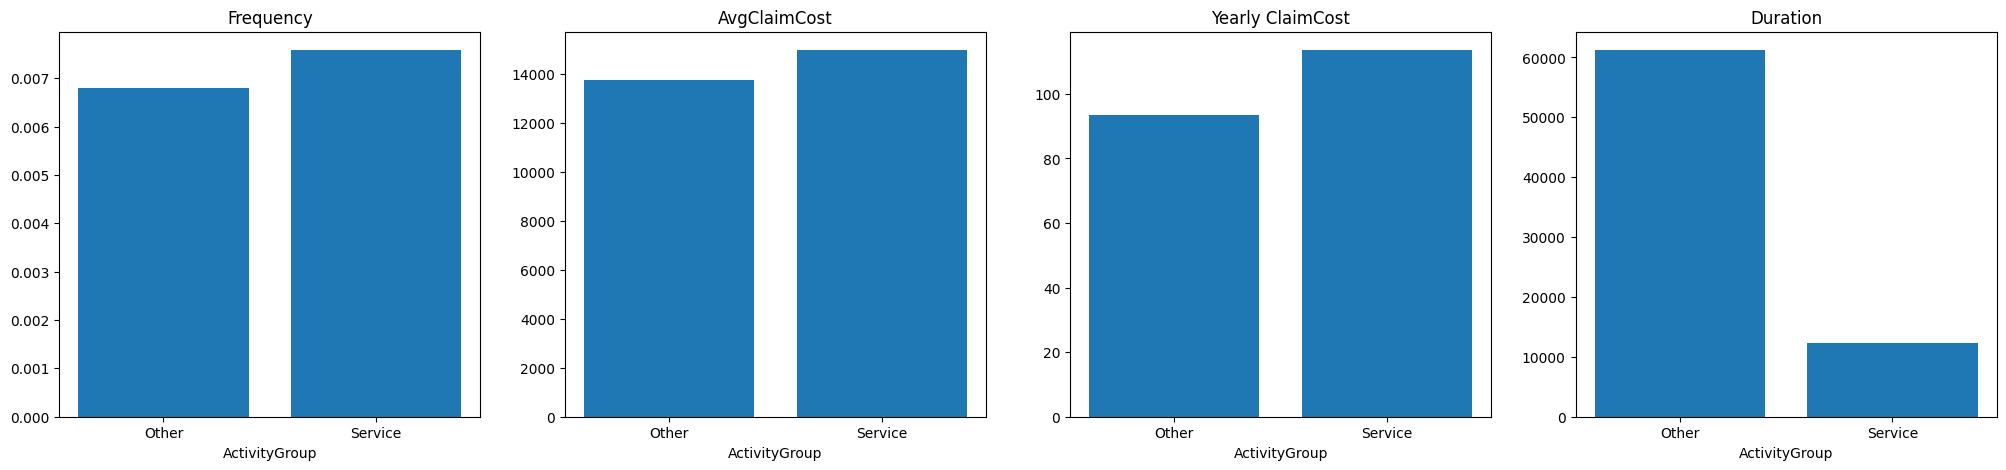

In [18]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["NumberOfClaims"] / df_agg_stat["Duration"])
plt.title("Frequency")

plt.subplot(142)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["NumberOfClaims"])
plt.title("AvgClaimCost")

plt.subplot(143)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["Duration"])
plt.title("Yearly ClaimCost")

plt.subplot(144)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["Duration"])
plt.title("Duration")

plt.show()

### ADD two grouping: 

#### Financial Rating

In [42]:


variable = "FinancialRating"
grouped_variable_name = "FinancialRatingGroup"

grouping_map = {
    "C": "Low", "CC": "Low", "CCC": "Low", "B": "Low",
    "BB": "Medium", "BBB": "Medium", "A": "Medium",
    "AA": "High", "AAA": "High",
    "IR": "Missing", "AN": "Missing",
}

df[grouped_variable_name] = df[variable].map(grouping_map)
df_eval[grouped_variable_name] = df_eval[variable].map(grouping_map)


df[grouped_variable_name] = df[grouped_variable_name].fillna("Missing")
df_eval[grouped_variable_name] = df_eval[grouped_variable_name].fillna("Missing")



In [43]:
df_agg_stat = df.groupby(grouped_variable_name).agg(aggregations)
df_agg_stat

,Duration,NumberOfClaims,ClaimCost
FinancialRatingGroup,,,
High,31863.9285,352,5221560.19
Low,8546.9747,24,323840.81
Medium,16807.6092,60,992466.19
Missing,16289.3654,73,576626.13


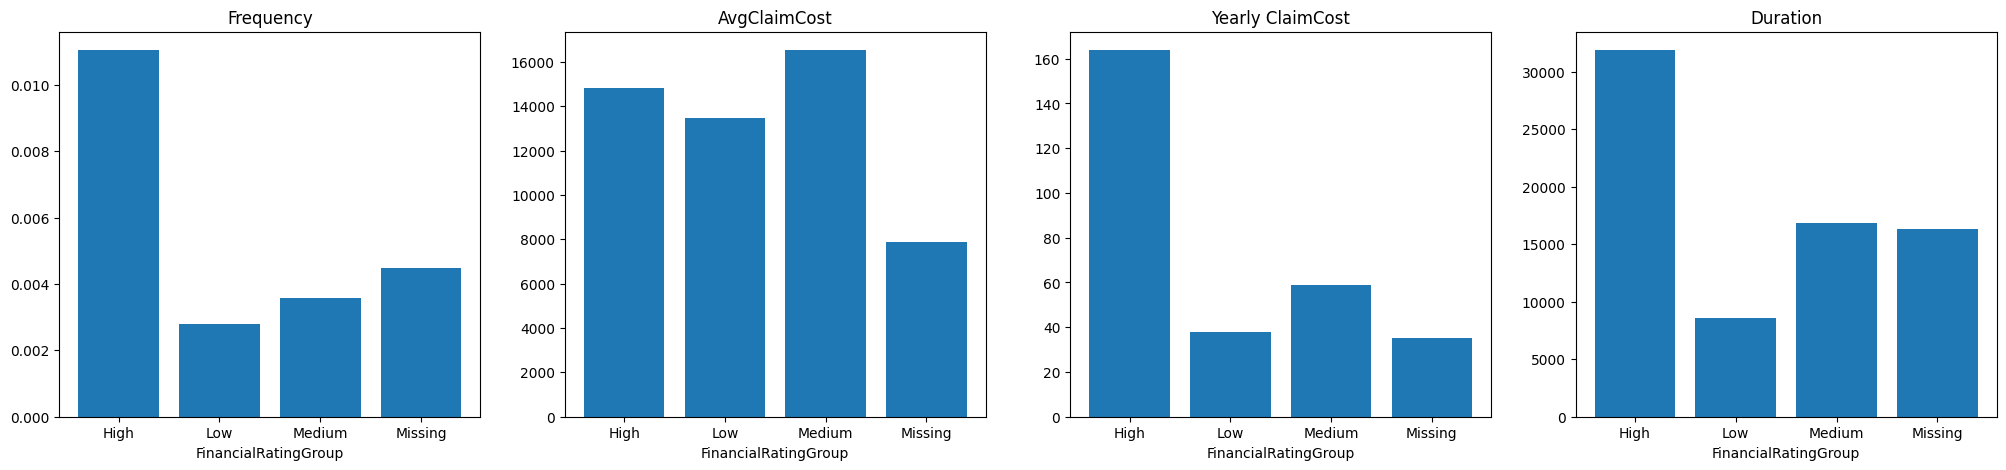

In [44]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["NumberOfClaims"] / df_agg_stat["Duration"])
plt.title("Frequency")

plt.subplot(142)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["NumberOfClaims"])
plt.title("AvgClaimCost")

plt.subplot(143)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["Duration"])
plt.title("Yearly ClaimCost")

plt.subplot(144)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["Duration"])
plt.title("Duration")

plt.show()

#### TravellingArea

In [45]:
variable = "TravellingArea"
grouped_variable_name = "TravellingAreaGroup"
grouping_map = {
    "Sweden": "Sweden",
    "Nordic countries": "Nordic",
    "Europe": "Europe",
    "Whole world": "World",
}

df[grouped_variable_name] = df[variable].replace(to_replace=grouping_map)
df[grouped_variable_name] = df[grouped_variable_name].fillna("Missing")

df_eval[grouped_variable_name] = df_eval[variable].replace(to_replace=grouping_map)
df_eval[grouped_variable_name] = df_eval[grouped_variable_name].fillna("Missing")

In [46]:
df_agg_stat = df.groupby(grouped_variable_name).agg(aggregations)
df_agg_stat

,Duration,NumberOfClaims,ClaimCost
TravellingAreaGroup,,,
Europe,4826.4254,17,197393.18
Nordic,3477.0124,3,33277.00
Sweden,9948.7627,6,50178.00
World,55255.6773,483,6833645.14


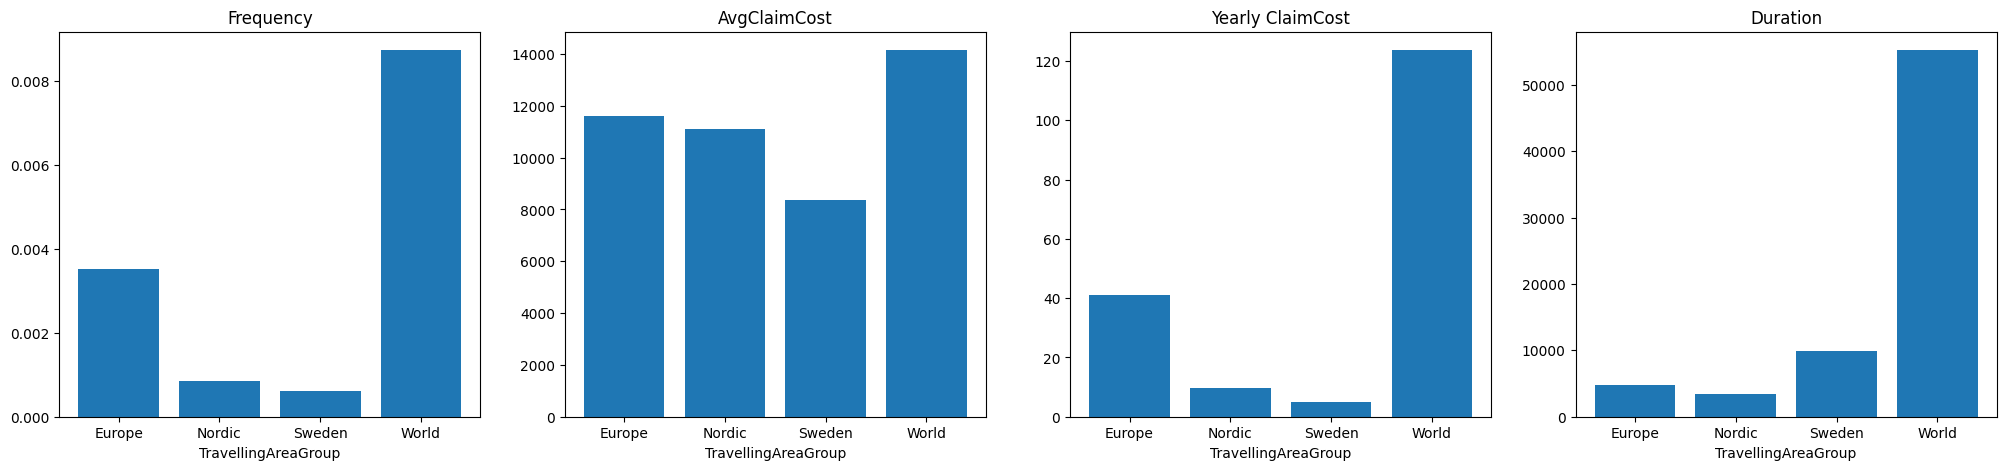

In [47]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["NumberOfClaims"] / df_agg_stat["Duration"])
plt.title("Frequency")

plt.subplot(142)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["NumberOfClaims"])
plt.title("AvgClaimCost")

plt.subplot(143)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["ClaimCost"] / df_agg_stat["Duration"])
plt.title("Yearly ClaimCost")

plt.subplot(144)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["Duration"])
plt.title("Duration")

plt.show()

## Aggregate data and calculate avereage claim cost within each tariff cell

Secondly, we want to aggregate the data. That is, instead of having one row per company & year, we want one row for each existing combination of variables, that is, one row for each tariff cell.

This code aggregates columns for Duration, # of Claims & ClaimCost, by two variables: NoPGroup and ActivityGroup

The aggregated data is stored in a new table, df_agg

You need to consider if there are any other variables you want to aggregate by, and modify the code accordingly

In [48]:
variables = ["ActivityGroup", "NoPGroup","FinancialRatingGroup","TravellingAreaGroup"]  # The varaibles to use in the model

df_agg = (
    df[variables + ["Duration", "NumberOfClaims", "ClaimCost"]]
    .groupby(variables)
    .agg("sum")
    .reset_index()
)  # Aggregation to tariff cells

/var/folders/ff/6hp3dqg92056jj3syv25sgg40000gn/T/ipykernel_19732/3037694253.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(variables)


In [49]:
# Calculating the average claim cost within each tariff cell
df_agg["AvgClaimCost"] = df_agg["ClaimCost"] / df_agg["NumberOfClaims"]

In [50]:
df_agg  # Display aggregated dataframe

,ActivityGroup,NoPGroup,FinancialRatingGroup,TravellingAreaGroup,Duration,NumberOfClaims,ClaimCost,AvgClaimCost
0,Other,01.<4,High,Europe,991.5292,4,14692.18,3673.045000
1,Other,01.<4,High,Nordic,754.5549,0,0.00,NaN
2,Other,01.<4,High,Sweden,1905.8526,1,17142.00,17142.000000
3,Other,01.<4,High,World,9677.6692,31,297684.48,9602.725161
4,Other,01.<4,Low,Europe,336.0333,2,7642.00,3821.000000
...,...,...,...,...,...,...,...,...
155,Service,05. >=100,Medium,World,12.1184,4,12068.00,3017.000000
156,Service,05. >=100,Missing,Europe,0.0630,0,0.00,NaN
157,Service,05. >=100,Missing,Nordic,0.0000,0,0.00,NaN
158,Service,05. >=100,Missing,Sweden,0.0000,0,0.00,NaN


# GLM analysis
Now we get to the fun part - the GLM analysis

First we have some helping functions
* get_model_coefficients: takes in model and variable for which we want the model factors and the confidence intervals
* plot_model_results: uses get_model_coefficients to plot factors and confidence intervals

Then we run frequency model and severity model separately. Remember to use the same variables in both models.

In [51]:
def get_model_coefficients(model, col_name, confidence_alpha=0.05):
    """Get coefficients from categorical variables"""
    coefs = np.exp(model.params[model.params.index.str.contains(col_name)])

    ref = coefs.index[-1]
    ref = re.sub(r".*?[\=]", "", ref, 1)
    ref = re.sub(r"[\)].*", "", ref)[1:-1]

    coefs.index = (
        coefs.index.str.replace(".*[\)]", "", regex=True)
        .str.replace("T.", "", regex=False)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
    )
    coefs = pd.concat([coefs,pd.Series([1], index=[ref])]).sort_index()

    conf_int = np.exp(
        model.conf_int(alpha=confidence_alpha, cols=None)[
            model.params.index.str.contains(col_name)
        ]
    )
    conf_int.index = (
        conf_int.index.str.replace(".*[\)]", "", regex=True)
        .str.replace("T.", "", regex=False)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
    )
    lower = pd.concat([conf_int[0],pd.Series([1], index=[ref])]).sort_index()
    upper = pd.concat([conf_int[1],pd.Series([1], index=[ref])]).sort_index()

    return coefs, lower, upper


def plot_model_result(
    model, variable, model_type_name, conf_int=True, fig_size=(5,5), return_fig=False
):
    coefs, lower, upper = get_model_coefficients(model, variable)

    fig = plt.figure(figsize=fig_size)
    plt.plot(coefs.index, coefs, label="risk")
    if conf_int:
        plt.plot(lower.index, lower, "g:", label="lower cofidence bound")
        plt.plot(upper.index, upper, "g:", label="upper confidence bound")
        plt.ylim(0, np.max(upper) + 0.1)
    plt.hlines(1, coefs.index[0], coefs.index[-1], linestyle="dotted", color="black")
    plt.xlabel(variable)
    plt.ylabel("Relative risk")
    plt.title(f"{model_type_name} factors for {variable}")
    plt.legend()
    if return_fig:
        return fig

## Frequency model
Here we use the Poisson distribution, NumberOfClaims as target and Duration as exposure measure to get the frequency

### Formula
The formula is on the form 'target variable ~ C(variable1,Treatment(reference="group name")) + ... '. As a starting point, the reference group can be chosen as the one with most duartion.

In [54]:
# Find highest duration
ref_nop = df.groupby('NoPGroup')['Duration'].sum().idxmax()
ref_act = df.groupby('ActivityGroup')['Duration'].sum().idxmax()
ref_fin = df.groupby('FinancialRatingGroup')['Duration'].sum().idxmax()
ref_travel = df.groupby('TravellingAreaGroup')['Duration'].sum().idxmax()



frequency_formula = (
    'NumberOfClaims ~ '
    'C(NoPGroup, Treatment(reference="' + str(ref_nop) + '")) + '
    'C(ActivityGroup, Treatment(reference="' + str(ref_act) + '")) + '
    'C(FinancialRatingGroup, Treatment(reference="' + str(ref_fin) + '")) + '
    'C(TravellingAreaGroup, Treatment(reference="' + str(ref_travel) + '"))'
)

/var/folders/ff/6hp3dqg92056jj3syv25sgg40000gn/T/ipykernel_19732/2714123204.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ref_nop = df.groupby('NoPGroup')['Duration'].sum().idxmax()


In [57]:
df_agg_filtered = df_agg[df_agg["Duration"] > 0.001].copy()
freq_model = glm(
    formula=frequency_formula,
    data=df_agg_filtered,
    family=sm.families.Poisson(),
    exposure=df_agg_filtered["Duration"],
    var_weights=None,
    missing="raise",
).fit()

In [58]:
# Display model summary
freq_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         NumberOfClaims   No. Observations:                  138
Model:                            GLM   Df Residuals:                      126
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -167.51
Date:                Sun, 15 Feb 2026   Deviance:                       169.63
Time:                        15:20:03   Pearson chi2:                     236.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9991
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          -5.4847      0.114    -47.987      0.000      -5.709      -5.261
C(NoPGroup, Treatment(reference="01.<4"))[T.02. 5-14]               0.4589      0.155      2.954      0.003       0.154       0.763
C(NoPGroup, Treatment(reference="01.<4"))[T.03. 15-49]              1.1074      0.154      7.177      0.000       0.805       1.410
C(NoPGroup, Treatment(reference="01.<4"))[T.04. 50-99]              1.6541      0.193      8.589      0.000       1.277       2.032
C(NoPGroup, Treatment(reference="01.<4"))[T.05. >=100]              3.1231      0.126     24.846      0.000       2.877       3.369
C(ActivityGroup, Treatment(reference="Other"))[T.Service]           0.1797      0.117      1.539      0.124      -0.049       0.409
C(FinancialRatingGroup, Treatment(reference="High"))[T.Low]        -0.7164      0.214     -3.346      0.001      -1.136      -0.297
C(FinancialRatingGroup, Treatment(reference="High"))[T.Medium]     -0.4869      0.144     -3.391      0.001      -0.768      -0.205
C(FinancialRatingGroup, Treatment(reference="High"))[T.Missing]    -0.9998      0.133     -7.536      0.000      -1.260      -0.740
C(TravellingAreaGroup, Treatment(reference="World"))[T.Europe]     -0.2313      0.249     -0.927      0.354      -0.720       0.258
C(TravellingAreaGroup, Treatment(reference="World"))[T.Nordic]     -1.5305      0.581     -2.634      0.008      -2.669      -0.392
C(TravellingAreaGroup, Treatment(reference="World"))[T.Sweden]     -1.6980      0.415     -4.094      0.000      -2.511      -0.885
===================================================================================================================================
"""

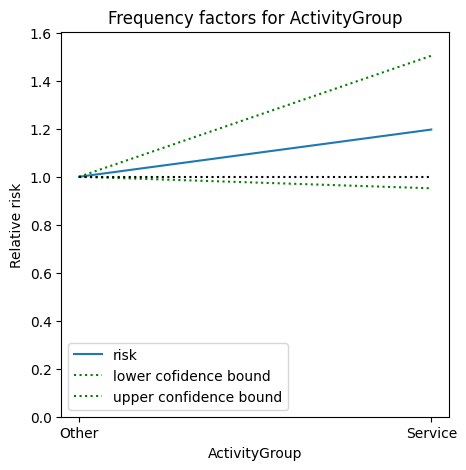

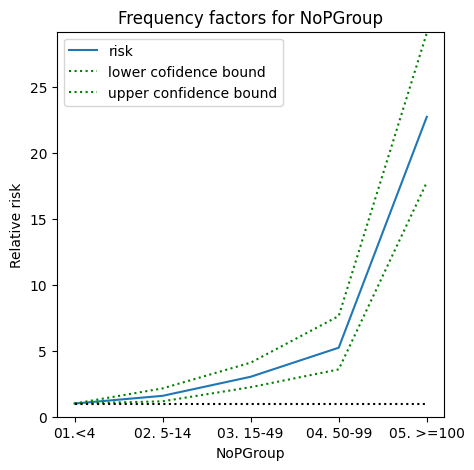

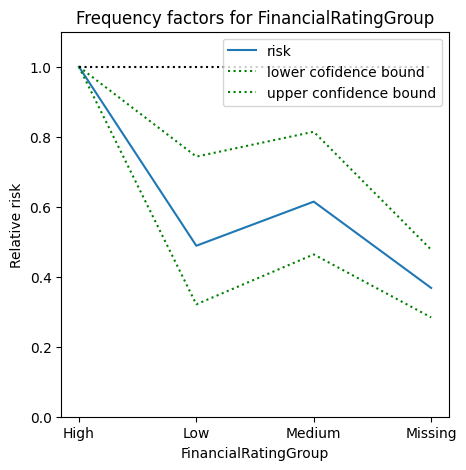

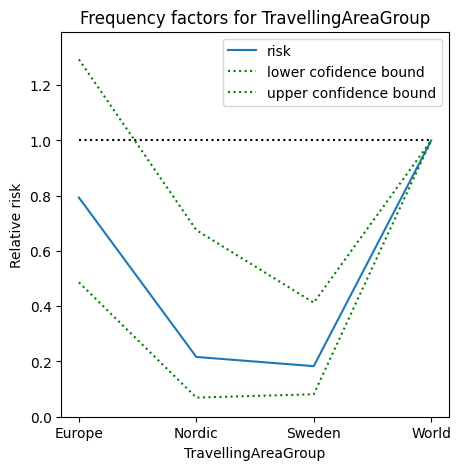

In [59]:
# Plot model factors and confidence intervals
for var in variables:
    coefs = get_model_coefficients(freq_model, var)[0]
    coefs.index.name = var
    coefs_df = pd.DataFrame(coefs, columns=[f"{var}_frequency_factor"])
    df = df.merge(coefs_df, on=var)

    plot_model_result(freq_model, var, "Frequency")

## Severity model
Here we use the Gamma distribution with a log link, average claim cost as target and number of claims as weight

In [60]:
# Find highest duration
ref_nop = df.groupby('NoPGroup')['Duration'].sum().idxmax()
ref_act = df.groupby('ActivityGroup')['Duration'].sum().idxmax()
ref_fin = df.groupby('FinancialRatingGroup')['Duration'].sum().idxmax()
ref_travel = df.groupby('TravellingAreaGroup')['Duration'].sum().idxmax()



severity_formula = (
    'NumberOfClaims ~ '
    'C(NoPGroup, Treatment(reference="' + str(ref_nop) + '")) + '
    'C(ActivityGroup, Treatment(reference="' + str(ref_act) + '")) + '
    'C(FinancialRatingGroup, Treatment(reference="' + str(ref_fin) + '")) + '
    'C(TravellingAreaGroup, Treatment(reference="' + str(ref_travel) + '"))'
)

In [61]:
link = sm.genmod.families.links.log()
severity_family = sm.families.Gamma(link=link)  # For severity model we use the Gamma family with the log link
df_sev = df_agg[df_agg["NumberOfClaims"] > 0]  # Remove tariff cells with 0 claims

sev_model = glm(
    formula=severity_formula,
    data=df_sev,
    family=severity_family,
    exposure=df_sev["NumberOfClaims"],
    var_weights=None,
    missing="raise",
).fit()

/Users/itdivisions/miniconda3/envs/mon_env/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/itdivisions/miniconda3/envs/mon_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/itdivisions/miniconda3/envs/mon_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/itdivisions/miniconda3/envs/mon_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or predic

In [62]:
sev_model.summary()

/Users/itdivisions/miniconda3/envs/mon_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/itdivisions/miniconda3/envs/mon_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/itdivisions/miniconda3/envs/mon_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         NumberOfClaims   No. Observations:                   50
Model:                            GLM   Df Residuals:                       38
Model Family:                   Gamma   Df Model:                           11
Link Function:                    log   Scale:                      1.4924e-32
Method:                          IRLS   Log-Likelihood:                 0.0000
Date:                Sun, 15 Feb 2026   Deviance:                  -1.7705e-15
Time:                        15:21:06   Pearson chi2:                 5.67e-31
No. Iterations:                   100   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        2.806e-17   5.27e-17      0.533      0.594   -7.52e-17    1.31e-16
C(NoPGroup, Treatment(reference="01.<4"))[T.02. 5-14]           -8.236e-18   4.77e-17     -0.173      0.863   -1.02e-16    8.52e-17
C(NoPGroup, Treatment(reference="01.<4"))[T.03. 15-49]           6.877e-17   5.61e-17      1.226      0.220   -4.11e-17    1.79e-16
C(NoPGroup, Treatment(reference="01.<4"))[T.04. 50-99]           7.595e-17   5.91e-17      1.286      0.199   -3.98e-17    1.92e-16
C(NoPGroup, Treatment(reference="01.<4"))[T.05. >=100]           7.246e-17   5.94e-17      1.220      0.222   -4.39e-17    1.89e-16
C(ActivityGroup, Treatment(reference="Other"))[T.Service]        6.257e-19   3.88e-17      0.016      0.987   -7.54e-17    7.66e-17
C(FinancialRatingGroup, Treatment(reference="High"))[T.Low]     -1.368e-16   5.35e-17     -2.555      0.011   -2.42e-16   -3.18e-17
C(FinancialRatingGroup, Treatment(reference="High"))[T.Medium]  -6.194e-17   5.38e-17     -1.152      0.249   -1.67e-16    4.35e-17
C(FinancialRatingGroup, Treatment(reference="High"))[T.Missing] -1.118e-16   4.63e-17     -2.415      0.016   -2.02e-16    -2.1e-17
C(TravellingAreaGroup, Treatment(reference="World"))[T.Europe]   4.203e-17   5.27e-17      0.798      0.425   -6.12e-17    1.45e-16
C(TravellingAreaGroup, Treatment(reference="World"))[T.Nordic]   9.645e-17   8.28e-17      1.165      0.244   -6.58e-17    2.59e-16
C(TravellingAreaGroup, Treatment(reference="World"))[T.Sweden]   5.091e-17   8.18e-17      0.622      0.534   -1.09e-16    2.11e-16
===================================================================================================================================
"""

In [63]:
coefs

TravellingAreaGroup
Europe    0.793483
Nordic    0.216428
Sweden    0.183049
World     1.000000
dtype: float64

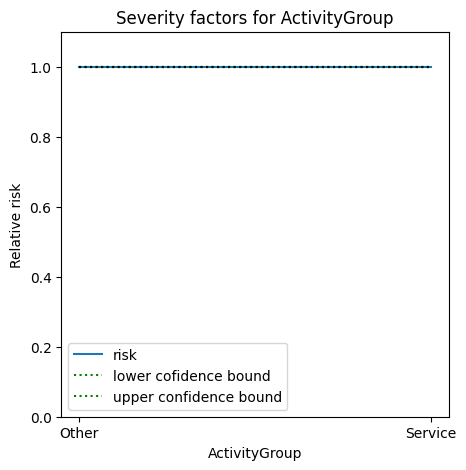

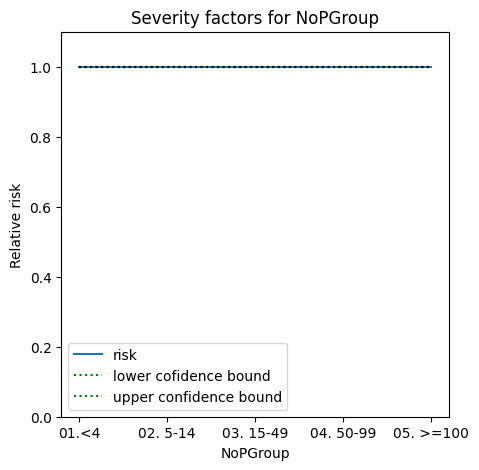

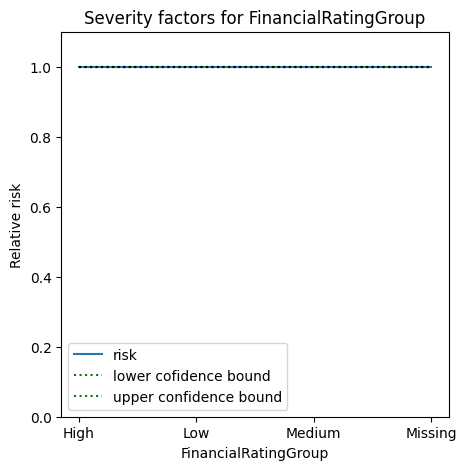

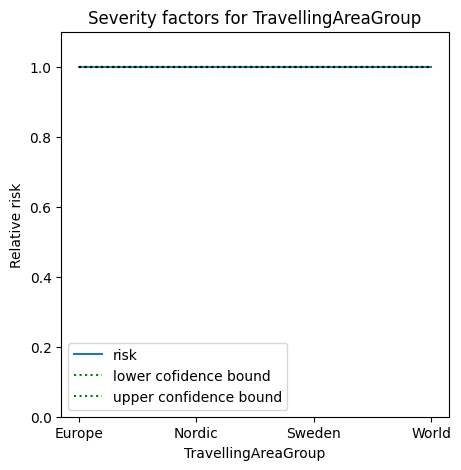

In [64]:
for var in variables:
    coefs = get_model_coefficients(sev_model, var)[0]
    coefs.index.name = var
    coefs_df = pd.DataFrame(coefs, columns=[f"{var}_severity_factor"])
    df = df.merge(coefs_df, on=var)

    plot_model_result(sev_model, var, "Severity")

## Combine models
When you are satisfied with the outputs from the severity and the frequency models, you should combine them to get the final variable factor, and in the end combine all variable factors to get the final model factor

In [ ]:
# For each variable used in the model, the factors from the frequency model and the factors from the severity model are multiplied
for var in variables:
    df[f"{var}_factor"] = df[f"{var}_frequency_factor"] * df[f"{var}_severity_factor"]

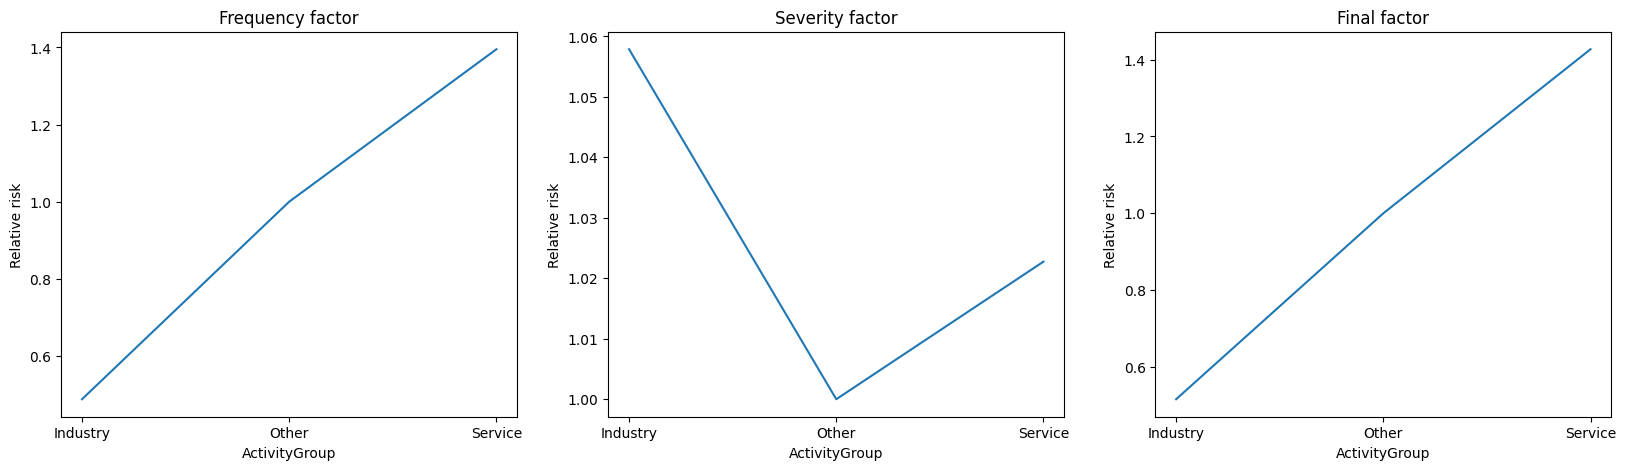

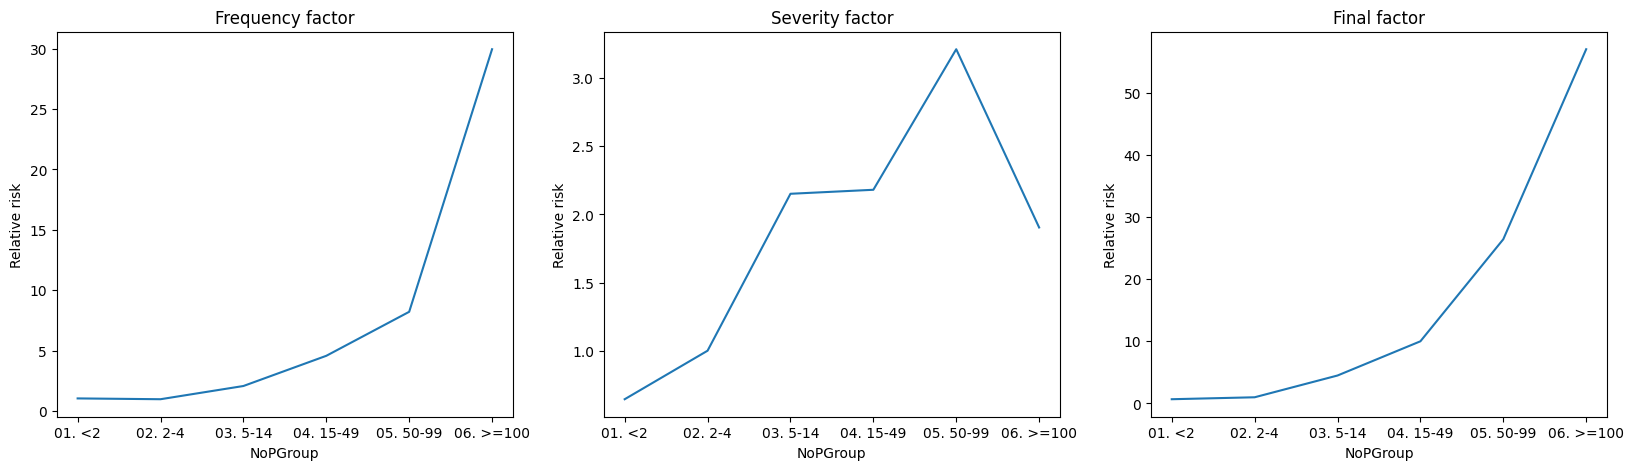

In [ ]:
# For each variable used in the model we can plot the factors from the frequency, severity and final variable factor
for var in variables:
    df_plot = (
        df.groupby(
            [var, f"{var}_frequency_factor", f"{var}_severity_factor", f"{var}_factor"]
        )
        .agg({"Duration": "sum"})
        .reset_index()
    )
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.plot(df_plot[var], df_plot[f"{var}_frequency_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Frequency factor")
    plt.subplot(132)
    plt.plot(df_plot[var], df_plot[f"{var}_severity_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Severity factor")
    plt.subplot(133)
    plt.plot(df_plot[var], df_plot[f"{var}_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Final factor")
    plt.show()

In [ ]:
# In the end, the factors from each varaible are multiplied to get the final differentiating factor
df.loc[:, "ModelPredictionFactor"] = 1
for var in variables:
    df["ModelPredictionFactor"] *= df[f"{var}_factor"]

# Model validation

## Gini validation
For each model we can create a Lorenz curve and get a gini score. The gini score is a good measure of how well the model risk asses the different tariff cells relatively to each other. 

Below there are help functions to
* Create a lorenz curve
* Create a gini score
* Create a gini plot with the help of the two above

In [ ]:
def lorentz_curve(x, y, sort_by):
    assert x.shape == y.shape
    df_l2 = (
        pd.DataFrame(data={"x": x, "y": y, "sort_by": sort_by})
        .groupby(["sort_by"], as_index=False)
        .sum()
    )
    x_no_ties = df_l2["x"]
    y_no_ties = df_l2["y"]
    sort_by_no_ties = df_l2["sort_by"]
    sort = np.argsort(sort_by_no_ties)
    x_cumsum = pd.concat(
        [pd.Series([0]), x_no_ties.iloc[sort].cumsum() / x_no_ties.sum()]
    )
    y_cumsum = pd.concat(
        [pd.Series([0]), y_no_ties.iloc[sort].cumsum() / y_no_ties.sum()]
    )
    lorentz = np.trapz(x=x_cumsum, y=y_cumsum)
    diag = np.trapz(x=x_cumsum, y=x_cumsum)
    area_between_curves = diag - lorentz
    return area_between_curves, x_cumsum, y_cumsum


def GiniScore(df, x, y, sort_by):
    oracle_area, oracle_x, oracle_y = lorentz_curve(
        df[x], df[y], df[y] / df[x]
    )  # perfect order
    area, x_cumsum, y_cumsum = lorentz_curve(
        df[x], df[y], df[sort_by]
    )  # prediction order
    gini = area / oracle_area  # area relative perfect area
    return gini


def CreateGiniPlot(df, x, y, i="", figsize=(8, 6)):
    oracle_area, oracle_x, oracle_y = lorentz_curve(df[x], df[y], df[y] / df[x])

    fig = plt.figure(figsize=figsize)

    plt.plot(oracle_x, oracle_y, label=f"Sorted by {y}, perfect model")
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="black",
        label="Random baseline " + i + " (Gini {:.3f})".format(0),
    )

    plt.xlabel(
        "Fraction of total "
        + df[x].name
        + "\n"
        + "(ordered by model from safest to riskiest)"
    )
    plt.ylabel("Fraction of total " + df[y].name)

    def AddGiniModel(sort_by):

        area, x_cumsum, y_cumsum = lorentz_curve(df[x], df[y], df[sort_by])
        plt.plot(
            x_cumsum,
            y_cumsum,
            label=f"Sorted by {df[sort_by].name} (NormGini {area/oracle_area:.3f})",
        )

        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(loc="upper left")

        gini = area / oracle_area
        return gini

    return AddGiniModel, fig

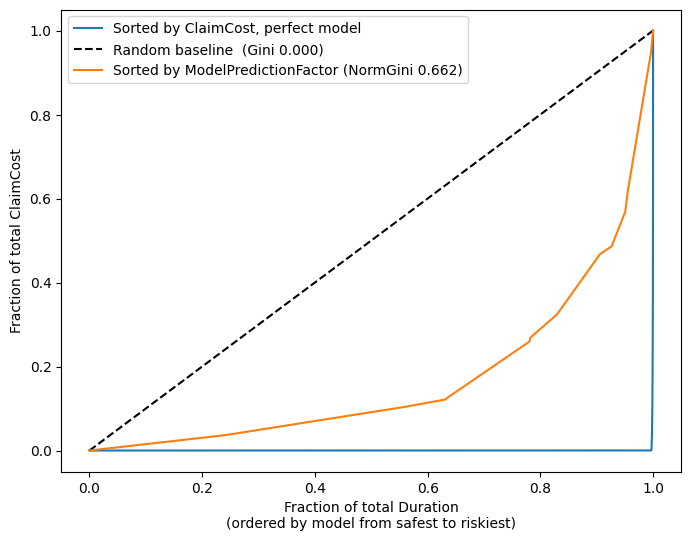

In [ ]:
gini, fig = CreateGiniPlot(
    df, "Duration", "ClaimCost"
)  # creates base line and lorenz curve for perfect model (ordered by claim cost which is the actual outcome)
gini_index = gini("ModelPredictionFactor")  # Ordered by your model
plt.show()

### Compare models with gini
It is possible to add two models to the same gini plot to compare them.

Below is an example where a second model (that only prices based on NumberOfPersons - the higher value, the higher price) is added to the gini plot to compare to the first model. 

Note that the NumberOfPersons-model looks best in this case and this can have several reasons. One is that it is more differentiated, since the number of persons are not grouped. When grouping numerical variables, the final factor curve is normally piecewise linear, with the linear parts being interpolations between the model factors. Using the Duration-weighted average value of the variable in each group as the knots for the model factors, try to make an interpolated model and evaluate this instead.

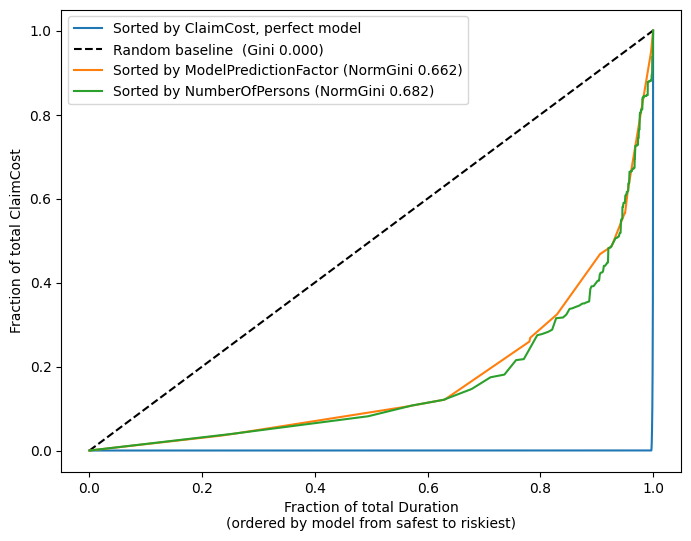

In [ ]:
gini, fig = CreateGiniPlot(
    df, "Duration", "ClaimCost"
)  # creates base line and lorenz curve for perfect model (ordered by claim cost which is the actual outcome)
gini_index = gini("ModelPredictionFactor")  # Ordered by your model
gini_index_2 = gini("NumberOfPersons")  # Ordered by your second model
plt.show()

## Risk ratio validation
Gini score only takes into account the relative risk between tariff cells. To see if the magnitude is correct, we can use other tests, for example risk ratio validation.

The goal here is to see an even risk ratio between groups, or at least more even than a random model, or that the model you are testing against.

We are here testing between groups in the variables used in the model, but any variables in the data can be used to test on.

Below, we calculate a random claim cost for each customer based on the total claim cost and the duration, and a predicted claim cost based on the model prediction, duration and total claim cost. Based on this set-up the target risk ratio is 1.

Note that above, the gini was better for a model only based on number of persons, but below when assuming a model that prices linearly on number of persons, the risk ratio becomes very uneven between groups, and our glm model performs much better.

In [ ]:
# Calculating random claim cost, and claim cost prediction
total_claim_cost = df["ClaimCost"].sum()
total_duration = df["Duration"].sum()
total_model_factor = (df["ModelPredictionFactor"] * df["Duration"]).sum()
total_model_factor_nop = (df["NumberOfPersons"] * df["Duration"]).sum()
df["random_claim_cost"] = df["Duration"] * total_claim_cost / total_duration
df["predicted_claim_cost"] = (
    df["ModelPredictionFactor"] * df["Duration"] * total_claim_cost / total_model_factor
)
df["predicted_claim_cost_nop"] = (
    df["NumberOfPersons"] * df["Duration"] * total_claim_cost / total_model_factor_nop
)

In [ ]:
df["predicted_claim_cost_nop"].sum()-total_claim_cost

9.313225746154785e-10

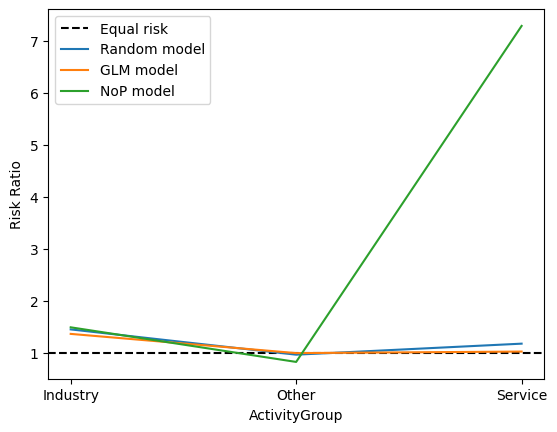

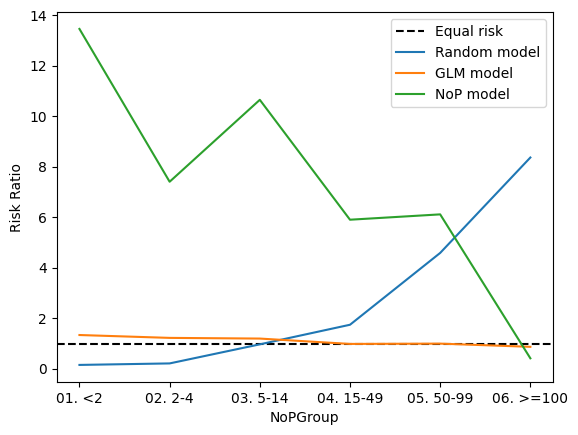

In [ ]:
# Aggregating per grouped variable and plotting
agg_dict = {
    "ClaimCost": "sum",
    "random_claim_cost": "sum",
    "predicted_claim_cost": "sum",
    "predicted_claim_cost_nop": "sum"
}
for var in variables:
    df_rr_agg = df.groupby(var).agg(agg_dict)
    fig, ax = plt.subplots()
    ax.axhline(1, color="k", linestyle="dashed", label="Equal risk")
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["random_claim_cost"],
        label="Random model",
    )
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["predicted_claim_cost"],
        label="GLM model",
    )
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["predicted_claim_cost_nop"],
        label="NoP model",
    )
    plt.xlabel(df_rr_agg.index.name)
    plt.ylabel("Risk Ratio")
    plt.legend()
    plt.show()

# Leveling
Now that you hav your model factors it is time to set a base level, that is the price that the factors will be multiplied with to get a price.

In pricing we want to provide a certain margin, so we ensure profitability of the portfolio.

This is done through leveling, where we set a target risk ratio we belive future risk ratio to be.

Increasing the leveling increase the profits, but may decrease the amount of customers.

Choose wisely as its these prices that will be provided on the evaluation

In [ ]:
df

,RiskYear,NumberOfPersons,ActivityCode,TravellingArea,DangerousAreas,CompanyAge,FinancialRating,Duration,ClaimCost,NumberOfClaims,...,ActivityGroup_frequency_factor,NoPGroup_frequency_factor,ActivityGroup_severity_factor,NoPGroup_severity_factor,ActivityGroup_factor,NoPGroup_factor,ModelPredictionFactor,random_claim_cost,predicted_claim_cost,predicted_claim_cost_nop
0,2018,58.0,L,Whole world,Excluded,70.075294,AA,0.9994,0.0,0,...,1.000000,8.228368,1.000000,3.212926,1.000000,26.437139,26.437139,96.727383,418.959581,65.326013
1,2018,30.0,G,Whole world,Excluded,66.841890,AAA,0.2519,0.0,0,...,1.395307,4.589830,1.022755,2.181232,1.427058,10.011486,14.286973,24.380256,57.067220,8.516639
2,2018,150.0,C,Whole world,Excluded,60.876114,AA,0.3340,0.0,0,...,1.000000,29.942616,1.000000,1.904547,1.000000,57.027111,57.027111,32.326342,302.027280,56.462037
3,2021,54.0,Q,Whole world,Excluded,63.608486,AAA,0.4956,0.0,0,...,1.000000,8.228368,1.000000,3.212926,1.000000,26.437139,26.437139,47.966871,207.761025,30.160871
4,2019,19.0,R,Whole world,Excluded,31.096510,A,0.8625,0.0,0,...,1.000000,4.589830,1.000000,2.181232,1.000000,10.011486,10.011486,83.477454,136.922860,18.468496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149481,2022,1.0,M,Sweden,Excluded,3.687885,AA,0.9720,0.0,0,...,1.000000,1.066683,1.000000,0.643927,1.000000,0.686866,0.686866,94.075461,10.586597,1.095431
149482,2022,2.0,R,Whole world,Excluded,1.938398,B,0.7366,0.0,0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,71.292165,11.680194,1.660277
149483,2018,2.0,F,Sweden,Excluded,20.999315,missing,0.5230,0.0,0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50.618792,8.293160,1.178828
149484,2020,1.0,F,Sweden,Excluded,2.469541,missing,0.3970,0.0,0,...,1.000000,1.066683,1.000000,0.643927,1.000000,0.686866,0.686866,38.423825,4.323949,0.447414


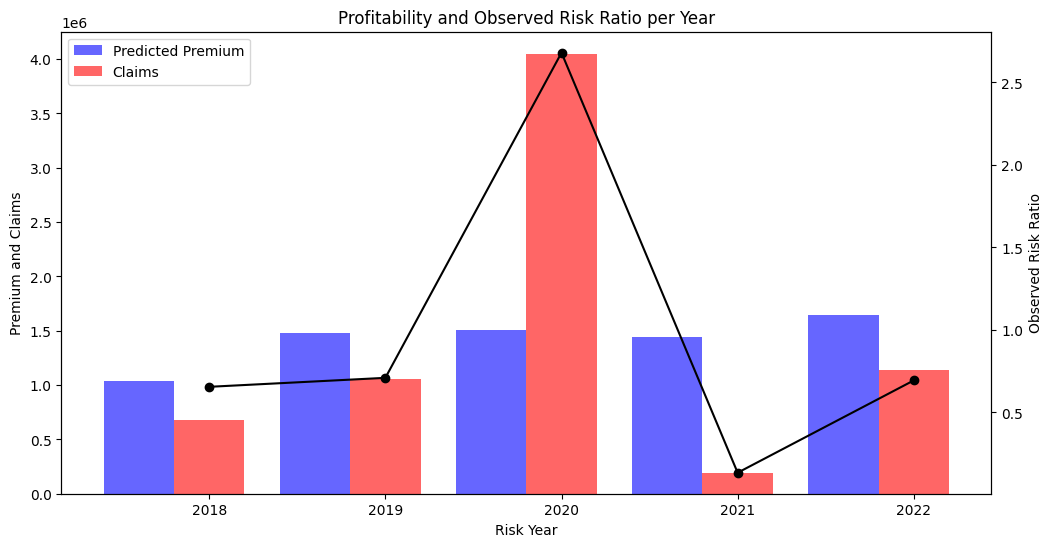

In [ ]:
risk_progress = df.groupby("RiskYear").agg({
    "ClaimCost": "sum",
    "predicted_claim_cost": "sum",
})
risk_progress['risk_ratio'] = risk_progress['ClaimCost'] / risk_progress['predicted_claim_cost']


fig, ax1 = plt.subplots(figsize=(12, 6))
# Plotting profits as a bar plot
ax1.bar(
    risk_progress.index-0.4,
    risk_progress["predicted_claim_cost"],
    color="blue",
    alpha=0.6,
    width=0.4
)
ax1.bar(
    risk_progress.index,
    risk_progress["ClaimCost"],
    color="red",
    alpha=0.6,
    width=0.4
)
ax1.set_xlabel("Risk Year")
ax1.set_ylabel("Premium and Claims")
ax1.tick_params(axis="y")
ax1.legend(["Predicted Premium", "Claims"], loc="upper left")

# Creating a second y-axis to plot the observed risk ratio
ax2 = ax1.twinx()
ax2.plot(risk_progress.index, risk_progress["risk_ratio"], color="black", marker="o")
ax2.set_ylabel("Observed Risk Ratio")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Profitability and Observed Risk Ratio per Year")
plt.show()

Now for future premiums we need to set a level, first we calculate the base level for the  *fair premium* which is the premium which equals the observed claims to our fitted premiums.

We then add a target risk ratio for what we belive the future risk-ratio will be and how much safety we want to apply to it?

In [ ]:
base_level = total_claim_cost / total_model_factor
base_level

15.856901672397353

In [ ]:
target_risk_ratio = 0.9
leveling_factor = base_level / target_risk_ratio
leveling_factor

17.618779635997058

Evaluate on the unknown data

In [ ]:
df_eval['frequency_factor'] = freq_model.predict(df_eval)
df_eval['severity_factor'] = sev_model.predict(df_eval)
df_eval["premium"] = (
    df_eval["frequency_factor"] * df_eval["severity_factor"] * leveling_factor
)

<Axes: >

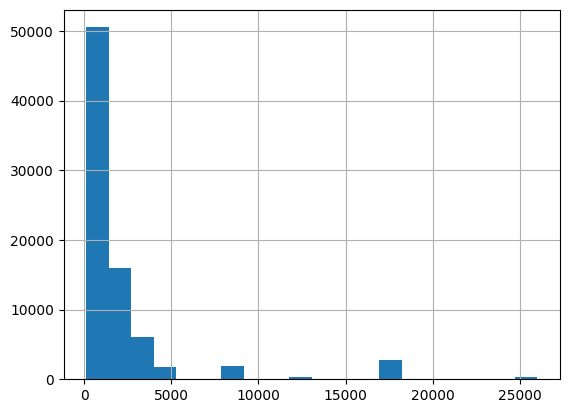

In [ ]:
df_eval["premium"].hist(bins=20)

In [ ]:
df_eval["premium"].describe()

count    79631.000000
mean      1823.162829
std       3825.873607
min        113.177816
25%        312.989301
50%        319.312587
75%       1437.962864
max      25985.979903
Name: premium, dtype: float64